# Теория приближения функций

## Алгоритм Ремеза

Написать программу для вычисления многочлена наилучшего приближения для функции $f$ в норме $C[a, b]$.
Требования к программе:
1. Программа должна содержать функцию, которая принимает на вход функцию $f$, отрезок $[a, b]$ и степень многочлена, и возвращает многочлен (в любом удобном виде, например, набор коэффициентов), а также $C[a, b]$-норму ошибки, оцененную по подробной сетке (10000 узлов) на отрезке $[a, b]$.
2. Функция должна вычислять многочлен наилучшего приближения итерационно, с помощью алгоритма Ремеза.
3. Программа должна вычислять многочлен для какой-то тестовой функции, и выводить $2$ рисунка:    
(a) на одном рисунке - график ошибки $e = f(x) - p_{n}(x)$ и график ошибки $f(x) - L_{n}(x)$ при интерполяции многочленом степени $n$ по значениям $f$ в узлах Чебышева (для интерполяции можно использовать готовую функцию, например, _BarycentricInterpolator_)  
(b) на одном рисунке график функции $f$ и график многочлена наилучшего приближения $p_{n}$.
4. Убедитесь, что алгоритм работает правильно: ошибка должна иметь $n + 2$ точки альтернанса.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BarycentricInterpolator
from scipy import optimize
%matplotlib inline

In [2]:
#функция для нахождения узлов Чебышева на отрезке [a, b]
def cheb_points(a, b, n):
    return (a + b) / 2 + (b - a) * np.cos((np.pi * (2 * np.arange(1, n + 1) - 1)) / (2 * n)) / 2

In [3]:
#фукнция для нахождения локальных минимумов в массиве (используется для нахождения минимумов по сетке)
def find_local_min(array):
    return np.argwhere(np.r_[True, array[1:] < array[:-1]] & np.r_[array[:-1] < array[1:], True]).flatten()

In [4]:
#фукнция для нахождения локальных максимумов в массиве (используется для нахождения максимумов по сетке)
def find_local_max(array):
    return find_local_min(-array)

In [5]:
#функция, реализующая алгоритм Ремеза (f - функция, a и b - границы отрезка, n - степень многочлена)
def remez_algorithm(f, a, b, n, accuracy = 1e-6, max_iter = None):
    #количество итераций
    num_iter = 0
    
    #находим узлы Чебышева на отрезке [a, b]
    x = cheb_points(a, b, n + 2)
    
    while True:
        #определяем матрицу для решения системы
        A = np.zeros((n + 2, n + 2))
        for i in range(n + 2):
            A[i] = np.array([x[i] ** k for k in range(n + 2)])
            A[i][n + 1] = (-1) ** (i + 1)

        #вектор правой части системы
        d = f(x)

        #решаем систему
        c = np.linalg.solve(A, d)

        #находим полином по решению системы
        polynom_coeff = c[:-1]
        polynom = np.poly1d(polynom_coeff[::-1])

        #функция ошибки
        error_function = lambda xs: f(xs) - polynom(xs)

        #задаем сетку для поиска локальных максимумов
        grid = np.linspace(a, b, 1000001)

        #считаем абсолютное значение ошибки в точках сетки и находим локальные максимумы по этой сетке
        abs_err = np.abs(error_function(grid))
        max_xs = grid[find_local_max(abs_err)]
        
        #проверяем на то, достаточно ли точек в массиве max_xs и добавляем в противном случае краевые точки отрезка
        if len(max_xs) < n + 2 and not np.isclose(max_xs[0], a):
            max_xs = np.insert(max_xs, 0, a)
        if len(max_xs) < n + 2 and not np.isclose(max_xs[-1], b):
            max_xs = np.append(max_xs, b)
        max_xs = max_xs[:(n + 2)]
        #обновляем массив узлов
        x = max_xs
        
        num_iter += 1
        
        #проверяем критерий остановки
        values = np.abs(error_function(x))
        if np.all(np.abs(values - values[0]) < accuracy):
            break
        if max_iter is not None and num_iter > max_iter:
            break
    
    #задаем сетку для подсчета ошибки и выводим результат
    new_grid = np.linspace(a, b, 10000)
    return polynom, np.abs(f(new_grid) - polynom(new_grid)).max()

In [6]:
def make_plots(function, a, b, n):
    #сетка
    grid = np.linspace(a, b, 10000)
    
    #интерполяционный многочлен, построенный по значениям f в узлах Чебышева
    cheb_xs = cheb_points(a, b, n)
    cheb_ys = function(cheb_xs)
    L_n = BarycentricInterpolator(cheb_xs, cheb_ys)
    
    #многочлен наилучшего приближения в C-норме
    p_n, C_norm = remez_algorithm(function, a, b, n)
    
    print('C[a, b]-norm for Remez algorithm: {}'.format(C_norm))
    print('C[a, b]-norm for interpolation: {}'.format(np.abs(function(grid) - L_n(grid)).max()))
    
    plt.figure(figsize = (12, 7))
    plt.plot(grid, function(grid), label = 'Function')
    plt.plot(grid, L_n(grid), label = 'Interpolation')
    plt.plot(grid, p_n(grid), label = r'Best approximation in $C[a, b]$-norm')
    plt.legend(loc = 'best', prop = {'size': 12})
    
    plt.figure(figsize = (12, 7))
    plt.plot(grid, function(grid) - L_n(grid), label = 'Error of interpolation')
    plt.plot(grid, function(grid) - p_n(grid), label = r'Error of best approximation in $C[a, b]$-norm')
    plt.legend(loc = 'best', prop = {'size': 12})

C[a, b]-norm for Remez algorithm: 0.0346897280821
C[a, b]-norm for interpolation: 0.127348903186


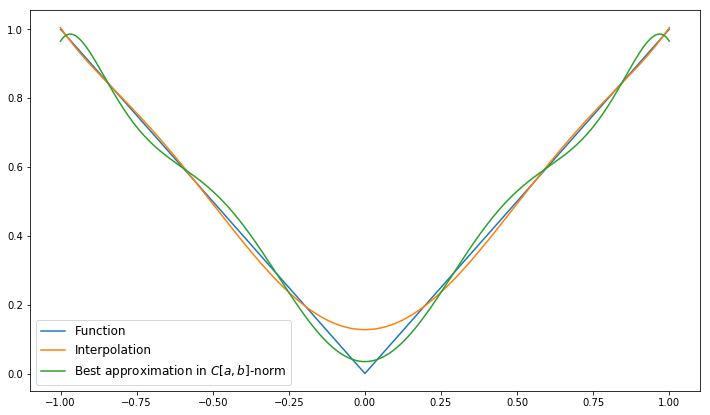

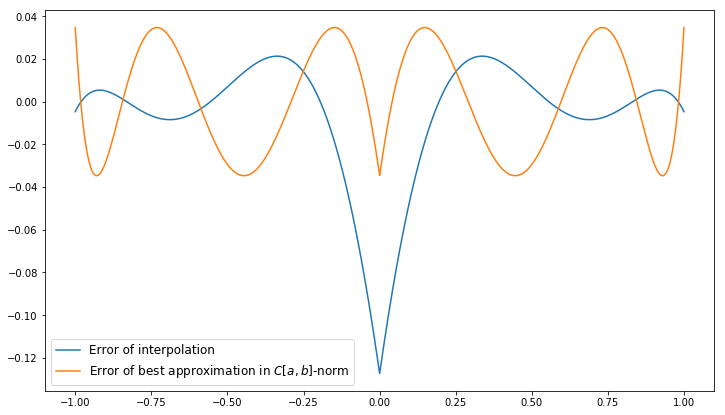

In [7]:
make_plots(lambda x: np.abs(x), -1., 1., 8)

C[a, b]-norm for Remez algorithm: 11.1876063987
C[a, b]-norm for interpolation: 28.1507674689


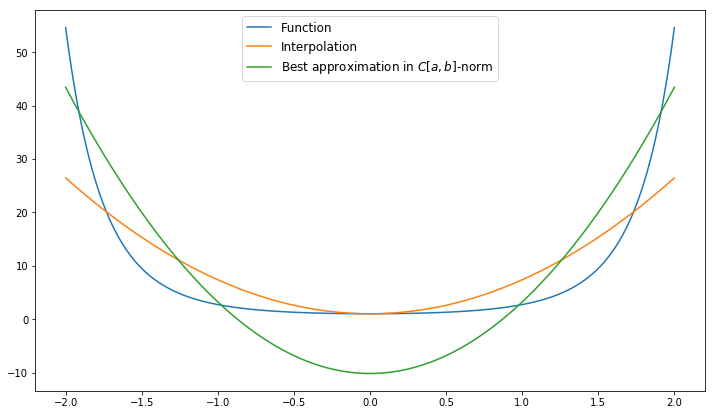

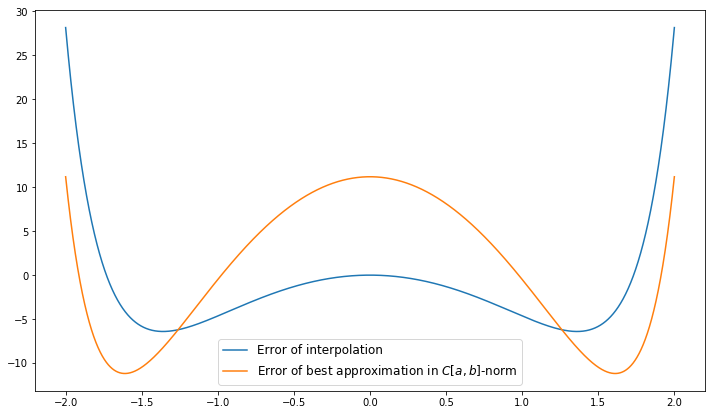

In [8]:
make_plots(lambda x: np.exp(x ** 2), -2., 2., 3)

C[a, b]-norm for Remez algorithm: 0.34880098614
C[a, b]-norm for interpolation: 1.04024830184


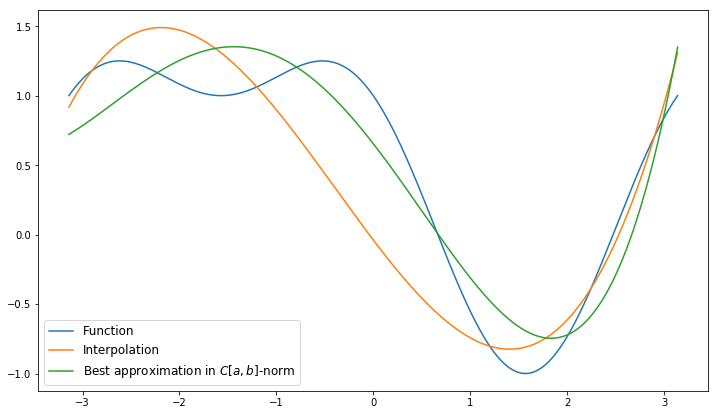

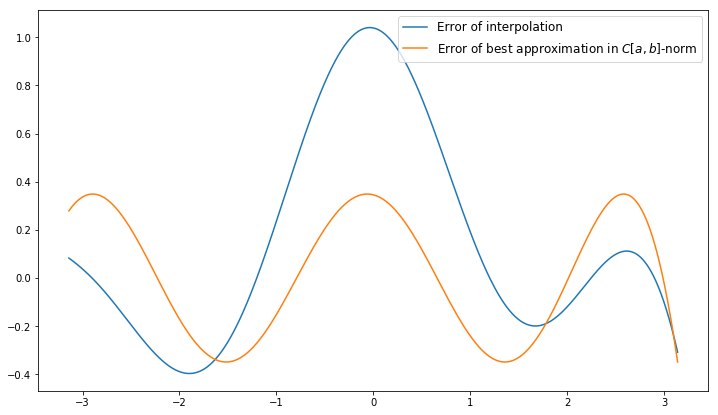

In [9]:
make_plots(lambda x: np.cos(x) ** 2 - np.sin(x), -np.pi, np.pi, 4)

По построенным графикам действительно можно утверждать, что алгоритм работает правильно, так как функция ошибки имеет не менее $(n + 2)$ точек альтернанса.